In [1]:
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
from tqdm import tqdm
%load_ext autoreload
%autoreload 2


In [2]:
from impy.definitions import *
from impy.constants import *
from impy.kinematics import EventKinematics
from impy import impy_config, pdata

In [3]:
# The event kinematics objects define all properties of the simulations setup.
# Some generators (such as DPMJET) require a maximal energy and nucleus mass to be
# set during initialization. This fist object should define that boundary 

event_kinematics = EventKinematics(
    ecm= 7 * TeV,
    p1pdg=2212,
    p2pdg=2212
    # nuc2_prop=(16,8)
)

In [4]:
# Configuration options can be set via the config. It's a yaml file in impy/impy_config.yaml
impy_config["user_frame"] = 'center-of-mass'
impy_config['tau_stable'] = 10e-12
impy_config['pi0_stable'] = True
# impy_config['debug_level'] = 5

In [5]:
# Create an instance of SIBYLL23D
m1 = 'SIBYLL23D'
gen_m1 = make_generator_instance(interaction_model_by_tag[m1])
gen_m1.init_generator(event_kinematics)

# Create an instance of DPMJETIII191
m2 = 'DPMJETIII191'
gen_m2 = make_generator_instance(interaction_model_by_tag[m2])
gen_m2.init_generator(event_kinematics)


impy.models.dpmjetIII.DpmjetIIIRun::init_generator(): Initializing DPMJET-III


In [6]:
# Example: generating pseudorapidity (eta) and Feynman-x distributions 

In [7]:
n_bins = 30
# Grid for Feynman-x
bins = np.linspace(-1,1.,n_bins+1)
grid = 0.5*(bins[1:] + bins[:-1])
widths = np.diff(bins)

# Pseudorapidity
eta_bins = np.linspace(-7,7,n_bins+1)
eta_grid = 0.5*(eta_bins[1:] + eta_bins[:-1])
widths_eta = np.diff(eta_bins)

n_events = 10000
norm = 1./float(n_events)


# We want to simulate pp interactions at 1 TeV center-of-mass
event_kinematics = EventKinematics(
    ecm= 1 * TeV,
    p1pdg=2212,
    p2pdg=2212
)

In [8]:
# Storage for xf histograms
m1_pions = np.zeros(n_bins)
m1_protons = np.zeros(n_bins)
m1_negpions = np.zeros(n_bins)

# For all charged particles
m1_charged_eta = np.zeros(n_bins)

# This loop generates the events using the energy, projectile, target and frame defined by event kinematics object
for event in tqdm(gen_m1.event_generator(event_kinematics, n_events)):
    # Filter the event stack for charged particles in final state. To include neutral use filter_final_state() instead.
    event.filter_final_state_charged()
    m1_protons += norm/widths*np.histogram(event.xf[event.p_ids == 2212],bins=bins)[0]
    m1_pions += norm/widths*np.histogram(event.xf[event.p_ids == 211],bins=bins)[0]
    m1_negpions += norm/widths*np.histogram(event.xf[event.p_ids == -211],bins=bins)[0]

    # To select all charged particles don't filter for particle ID
    m1_charged_eta += norm/widths_eta*np.histogram(event.eta, bins=eta_bins)[0]
    

10000it [00:02, 4283.10it/s]


In [9]:
# Do the same for DPMJETIII191

# Storage for histograms
m2_pions = np.zeros(n_bins)
m2_protons = np.zeros(n_bins)
m2_negpions = np.zeros(n_bins)

# For all charged particles
m2_charged_eta = np.zeros(n_bins)

# This loop generates the events using the energy, projectile, target and frame defined by event kinematics object
for event in tqdm(gen_m2.event_generator(event_kinematics, n_events)):
    # Filter the event stack for charged particles in final state. To include neutral use filter_final_state() instead.
    event.filter_final_state_charged()
    m2_protons += norm/widths*np.histogram(event.xf[event.p_ids == 2212],bins=bins)[0]
    m2_pions += norm/widths*np.histogram(event.xf[event.p_ids == 211],bins=bins)[0]
    m2_negpions += norm/widths*np.histogram(event.xf[event.p_ids == -211],bins=bins)[0]

    # To select all charged particles don't filter for particle ID
    m2_charged_eta += norm/widths_eta*np.histogram(event.eta, bins=eta_bins)[0]
    

10000it [00:04, 2442.10it/s]


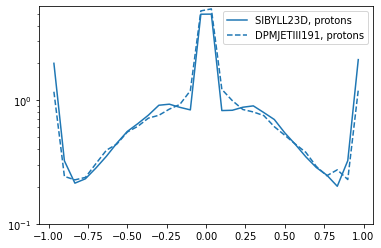

In [10]:
l=plt.plot(grid, m1_protons,label=m1 + ', protons')[0]
plt.plot(grid, m2_protons,c=l.get_color(), ls='--',label=m2 + ', protons')

plt.ylim(1e-1,)
plt.semilogy()
plt.legend()

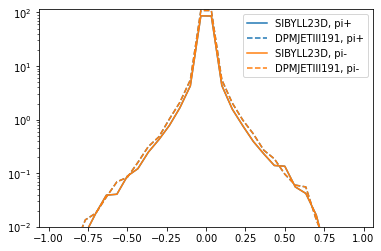

In [11]:
l=plt.plot(grid, m1_pions,label=m1 + ', pi+')[0]
plt.plot(grid, m2_pions,c=l.get_color(), ls='--',label=m2 + ', pi+')
l=plt.plot(grid, m1_pions,label=m1 + ', pi-')[0]
plt.plot(grid, m2_pions,c=l.get_color(), ls='--',label=m2 + ', pi-')

plt.ylim(1e-2,)
plt.semilogy()
plt.legend()

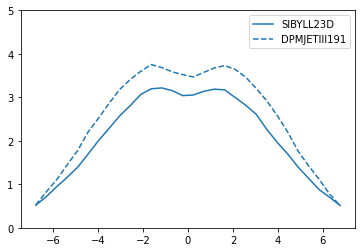

In [12]:
l=plt.plot(eta_grid, m1_charged_eta, label=m1)[0]
plt.plot(eta_grid, m2_charged_eta,c=l.get_color(), ls='--', label=m2)
plt.ylim(0,5)
plt.legend()

In [13]:
# Looking at event lists (change gen_m1 to gen_m2 for DPMJET)

for event in gen_m1.event_generator(event_kinematics, 3):
    event.filter_final_state_charged()
    print('Event {5:4}   {0:8} {1:10} {2:10} {3:10} {4:10}'.format('pid', 'px', 'py', 'pz', 'e', event.nevent))
    for ip, (pid, x, y, z, e) in enumerate(zip(event.p_ids, event.px, event.py, event.pz, event.en)):
        print('   {5:4}: {0:8} {1:10.2e} {2:10.2e} {3:10.2e} {4:10.2e}'.format(pid, x, y, z, e, ip))

Event 10000   pid      px         py         pz         e         
      0:      211   6.69e-01   1.72e-02   1.19e+00   1.37e+00
      1:     2212  -7.75e-01  -1.88e-01   2.36e+00   2.66e+00
      2:      321  -1.08e+00  -7.22e-03  -1.37e-02   1.19e+00
      3:     -211  -1.07e+00   5.26e-01  -4.13e-01   1.27e+00
      4:      211  -2.98e-01  -6.68e-02  -6.18e-01   7.03e-01
      5:      321   2.78e-01   6.70e-01  -1.34e-01   8.87e-01
      6:      211  -7.19e-02  -1.83e-01   6.61e+00   6.62e+00
      7:     -211   2.38e-01  -1.80e-01   1.51e+00   1.55e+00
      8:     -211   2.25e-01  -4.65e-01  -9.64e-01   1.10e+00
      9:     -211  -2.18e-01   9.47e-01  -3.19e+01   3.19e+01
     10:      211  -4.02e-01  -7.05e-01  -1.46e+02   1.46e+02
     11:      211  -8.08e-02   3.29e-01  -5.85e+01   5.85e+01
     12:     -211  -1.48e-01   7.08e-01   1.44e+00   1.61e+00
     13:     -321  -1.57e-01   6.86e-01   1.78e+01   1.78e+01
     14:      321   2.69e-01  -2.42e-01   8.60e+00   8.62e+00
   